# MNIST AutoEncoder-LDM Digit Drawing Model:
Plan: to build a conditioned LDM model to generate hand-drawn digits.
To do this we need to...
* Imports
* Data collection and preprocessing
* Buidling the AutoEncoder
    * At least one ResNet block in Encoder
    * At least one TConv layer in Decoder
    * See good performance in training
    * See strong class seperation in tSNE 
* Construct dataset of latent representations
* Build a denoising UNet and training loop
    * Skip connections and residual skip connections
    * Resnet and transpose resnet blocks
    * Self attention heads
* Train and show off results!

## To-Do:
* Fix early stopping
* Beef up U-Net
* Tidy up Autoencoder
* General clarification and tidying up
    * Fix early stopping function
* Double check that model parameter saving and loading is working well
  

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch import nn

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import torch.optim as optim 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# Data is build into torch vision here: https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html
test_data = datasets.MNIST(
    root='./data',
    train=False, # This is the test data
    download=True, 
    transform=ToTensor()
)

train_data = datasets.MNIST(
    root='./data',
    train=True, # This is the test data
    download=True, 
    transform=ToTensor()
)


In [5]:
from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


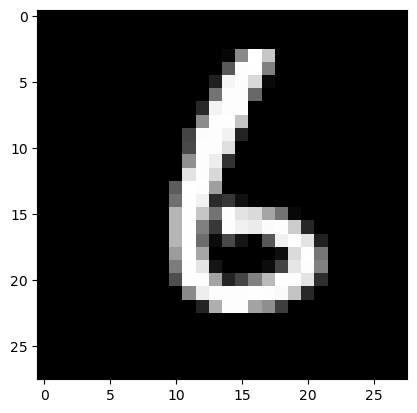

Label: 6


In [7]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Build an AutoEncoder:

In [119]:
class ResidualBlock(nn.Module): # Residual block, modelled after ResNets: https://en.wikipedia.org/wiki/Residual_neural_network
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels),
                                   nn.ReLU(),
                                   )
        self.conv2 = nn.Sequential(nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                                   nn.BatchNorm2d(out_channels),
                                  )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class Encoder(nn.Module): # Encoder block of Autoencoder. Could use tidying up
    def __init__(self, ResidualBlock, batch_size, L_dim):
        super(Encoder, self).__init__()

        self.L_dim = L_dim
        self.batch_size = batch_size
        pixels = 28**2
        pixelsd4 = int(pixels/4)
        
        self.resnet = ResidualBlock(1, 1)
        
        self.fc1 = nn.Linear(pixels, pixels)
        self.mp1 = nn.MaxPool1d(2)  # Reducing the pooling kernel size to avoid collapsing dimensions
        self.bn1 = nn.BatchNorm1d(pixels//2)  # Updated to match new output shape after pooling
        self.fc2 = nn.Linear(pixels//2, L_dim)  # Adjusted to match output size from BatchNorm1d
        
    def forward(self, x):
        x = self.resnet(x)
        x = torch.reshape(x, [x.shape[0], 28**2])  # Use dynamic batch size instead of hardcoded batch_size
        
        x = self.fc1(x)
        x = F.relu(x)
        x = x.unsqueeze(1)  # Adding a channel dimension to match MaxPool1d input requirements
        
        x = self.mp1(x)
        x = x.squeeze(1)  # Removing the channel dimension post-pooling
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = x + torch.randn_like(x) # Adding noise is critical to force the decoder to learn more generally
        return x  # This is the latent space z as a vector [batch_size, L_dim]
        

class Decoder(nn.Module): # Decoder, could also use cleaning up. Clearly gets the job done though! 
    def __init__(self, L_dim):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        # Fully connected layers - blow up latent space to a perfect square dimension for Tconv
        self.fc1 = nn.Linear(L_dim, 128)  # [batch_size, L_dim] -> [batch_size, 128]
        self.fc2 = nn.Linear(128, 256)
        self.bn1 = nn.BatchNorm1d(256) 
        
        # Transposed convolution layers
        self.Tconv1 = nn.ConvTranspose2d(1, 32, (2, 2), 2, 2)  
        self.bn2 = nn.BatchNorm2d(32)
        self.Tconv2 = nn.ConvTranspose2d(32, 1, (2, 2), 2, 1)  
        
        # Max pooling
        self.max_pool1 = nn.MaxPool2d(2, 2)
        
        # Fully connected layers for reconstruction - patch holes or artifacts from Tconv
        self.fc3 = nn.Linear(729, 784)
        self.fc4 =nn.Linear(784, 784)

    def forward(self, x): 
        
        # Fully connected path
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = self.bn1(x)
        x = F.relu(x)
        
        # Reshape dynamically based on the batch size
        batch_size = x.size(0)
        x = torch.reshape(x, (batch_size, 1, 16, 16))
        
        # Transposed convolutional path
        x = F.relu(self.Tconv1(x))
        x = self.bn2(x)
        x = F.relu(self.Tconv2(x))  # New TConv layer
        x = self.max_pool1(x)
        
        # Reshape for final fully connected layers
        x = torch.reshape(x, (batch_size, 729)) # ugly hardcoded dim
        x = F.relu( self.fc3(x) )
        x = F.relu( self.fc4(x) )
        
        # Reshape to match MNIST image size (28x28)
        x = torch.reshape(x, (batch_size, 1, 28, 28))  # No hardcoded batch size

        return x  # The reconstruction

        
class AutoEncoder(nn.Module):
    def __init__(self, ResidualBlock, Encoder, Decoder, batch_size, L_dim = 64): 
        super(AutoEncoder, self).__init__()
        
        self.encoder = Encoder(ResidualBlock, batch_size, L_dim)
        self.decoder = Decoder(L_dim)
        
    def forward(self, x): 
        x = self.encoder(x)
        x = self.decoder(x)
        return x 

In [121]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping: # fix this, it doesn't seem to be working.
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss_0, loss_1 ):
        if (loss_0 - loss_1) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True


def train(model, train_loader, epochs, opt):
    # Loss stuff
    # early_stopping = EarlyStopping(tolerance=5, min_delta=1)
    lr = 1e-4
    weight_decay = 1e-5
    if opt == True:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay = weight_decay)
    
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    mse = nn.MSELoss()
    losses = []
    losses.append(100)
    # L1 = nn.L1Loss()
    # alpha = 0.75
    
    plt.xlabel("Epochs")
    plt.ylabel("Loss") 
#     plt.ylim(0, 100) # A guess
    
    for epoch in range(epochs):
        
        model.train()
        running_loss = 0.0
        for data, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = mse(outputs, data) # alpha * mse(outputs, data ) + (1 - alpha) * L1(outputs, data )
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        plt.scatter(epoch, running_loss, color = 'r')
        print(f'Epoch [{epoch +1}/{epochs}], Loss: {running_loss:.4f}')
        
        if epoch%5 ==0: 
            # Additional information
            PATH = "model.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                }, PATH)
            
        # # early stopping - currently seems broken 
        # losses.append(running_loss)
        # early_stopping(losses[epoch], losses[epoch-1])
        # if early_stopping.early_stop:
        #     print("We are at epoch:", epoch)
        #     PATH = "model.pt"
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'loss': running_loss,
        #         }, PATH)
        #     print("Model saved")
        #     break

# Training

Epoch [1/25], Loss: 75.7068
Epoch [2/25], Loss: 46.8460
Epoch [3/25], Loss: 39.0658
Epoch [4/25], Loss: 33.8313
Epoch [5/25], Loss: 30.4864
Epoch [6/25], Loss: 28.3890
Epoch [7/25], Loss: 26.8849
Epoch [8/25], Loss: 25.7856
Epoch [9/25], Loss: 24.8305
Epoch [10/25], Loss: 24.0317
Epoch [11/25], Loss: 23.3333
Epoch [12/25], Loss: 22.7813
Epoch [13/25], Loss: 22.2009
Epoch [14/25], Loss: 21.7714
Epoch [15/25], Loss: 21.2713
Epoch [16/25], Loss: 20.9408
Epoch [17/25], Loss: 20.6224
Epoch [18/25], Loss: 20.3645
Epoch [19/25], Loss: 20.1467
Epoch [20/25], Loss: 19.8353
Epoch [21/25], Loss: 19.6377
Epoch [22/25], Loss: 19.4117
Epoch [23/25], Loss: 19.1740
Epoch [24/25], Loss: 19.0869
Epoch [25/25], Loss: 18.8541


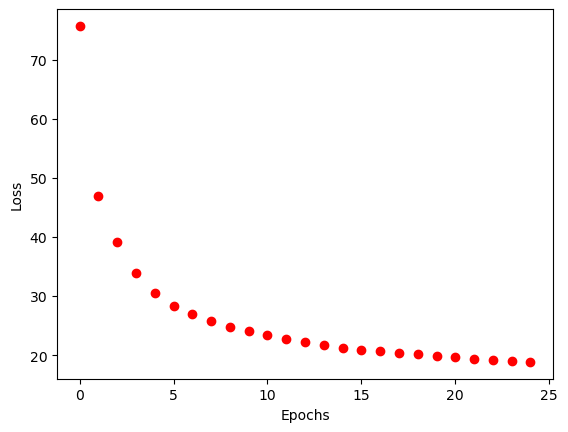

In [167]:
epochs = 25
L_dim = 32
model = AutoEncoder(ResidualBlock, Encoder, Decoder, batch_size, L_dim).to(device)
train(model, train_dataloader, epochs, True) # train w/ Adam optimizer

torch.Size([32, 1, 28, 28])


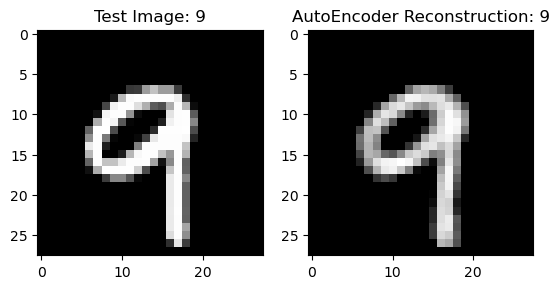

In [168]:
test_features, test_labels = next(iter(test_dataloader))
print(test_features.shape)
recon = model(test_features)[0]

true = test_features[0].squeeze()
recon = torch.reshape(recon, (28,28))
recon = recon.detach().numpy()
# recon = (recon/recon.max()).detach().numpy() # Unnecessary scaling

label = int( test_labels[0] )

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Test Image: '+str(  label  ) )
ax1.imshow(true, cmap="gray")

ax2.set_title('AutoEncoder Reconstruction: '+str(  label  ) ) 
ax2.imshow(recon, cmap="gray")


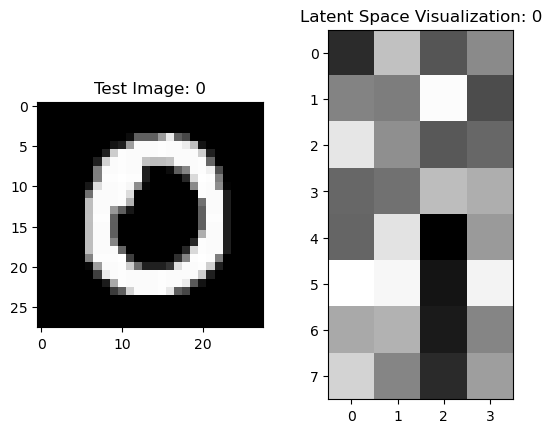

In [169]:
test_features, test_labels = next(iter(test_dataloader))


recon = model.encoder(test_features)[0]

true = test_features[0].squeeze()
recon = torch.reshape(recon, (8, 4))
recon = recon.detach().numpy()
# # recon = (recon/recon.max()).detach().numpy() # Unnecessary scaling

label = int( test_labels[0] )

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Test Image: '+str(  label  ) )
ax1.imshow(true, cmap="gray")

ax2.set_title('Latent Space Visualization: '+str(  label  ) ) 
ax2.imshow(recon, cmap="gray")


# Check tSNE visualization for strong class clustering:

In [171]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Set up t-SNE and plotting
def plot_tsne(latent_vectors, labels, set):
    tsne = TSNE(n_components=2, random_state=42)  # t-SNE reduces to 2D
    latent_2d = tsne.fit_transform(latent_vectors)
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=latent_2d[:, 0], y=latent_2d[:, 1],
        hue=labels, palette=sns.color_palette("hsv", 10),
        legend='full', alpha=0.7
    )
    plt.title(f"t-SNE Visualization of MNIST {set} Data Latent Space")
    plt.show()

# Generate latent representations for a batch of MNIST images
def get_latent_space(model, dataloader, device='cpu'):
    latent_vectors = []
    labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            label = label.to(device)
            
            # Pass through encoder
            latent_rep = model.encoder(images)  # Get latent space from encoder
            
            # Store the latent vectors and corresponding labels
            latent_vectors.append(latent_rep.cpu().numpy())
            labels.append(label.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels


In [172]:
# Use the model and test dataloader to get latent representations of the test set
test_latent_vectors, test_labels = get_latent_space(model, test_dataloader)

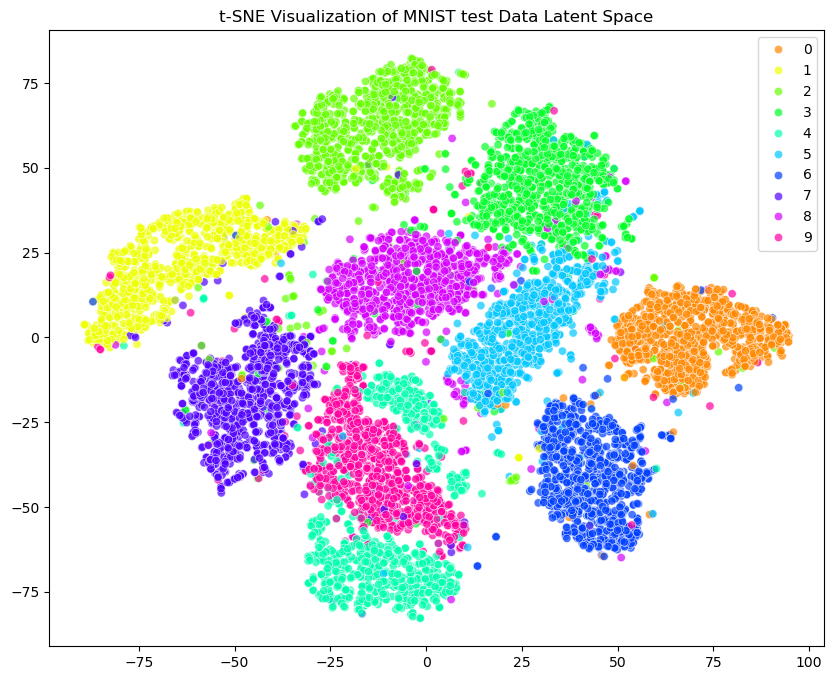

In [173]:
# Visualize the latent space
plot_tsne(test_latent_vectors, test_labels, 'test') # tSNE of the test set

## Good testing class eperation in tSNE space, the expected confusion groups are clustered together (3,5,8) and (4,9)

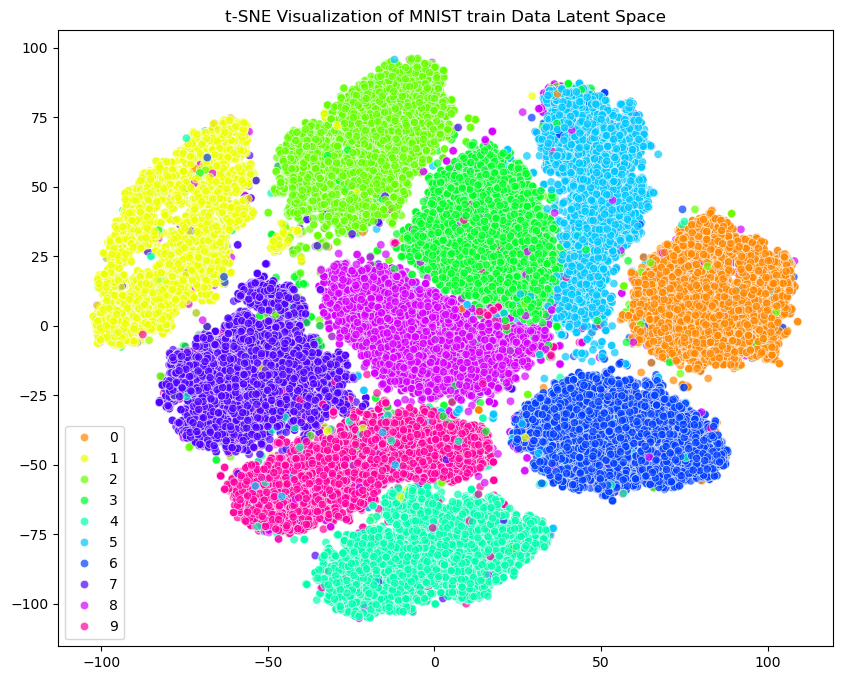

In [175]:
train_latent_vectors, train_labels = get_latent_space(model, train_dataloader)
plot_tsne(train_latent_vectors, train_labels, 'train') # tSNE of the training set

## Very solid class seperation on the training set! A good indication of successful training. No real class cluster overlaps, indicating that AE learned a very robust class seperation

# Construct dataloader of latent representations for LDM training:

In [178]:
from torch.utils.data import Dataset, DataLoader

# Generate latent representations for a batch of MNIST images
def get_latent_space(model, dataloader, device='cpu'):
    latent_vectors = []
    labels = []

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, label in dataloader:
            images = images.to(device)
            label = label.to(device)
            
            # Pass through encoder
            latent_rep = model.encoder(images)  # Get latent space from encoder
            
            # Store the latent vectors and corresponding labels
            latent_vectors.append(latent_rep.cpu().numpy())
            labels.append(label.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)
    
    return latent_vectors, labels
# Custom dataset class for latent space
class LatentMNISTDataset(Dataset):
    def __init__(self, encoder, mnist_dataset):
        self.encoder = encoder
        self.mnist_dataset = mnist_dataset

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Generate latent space representation using the encoder
        with torch.no_grad():
            latent_rep = self.encoder(image.unsqueeze(0))  # Add batch dim
        return latent_rep.squeeze(0), label


In [179]:
# Assuming get_latent_space returns latent_vectors and labels
train_latent_vectors, labels = get_latent_space(model, train_dataloader)

In [180]:
# Create the dataset
train_latent_dataset = LatentMNISTDataset(model.encoder, train_data)

In [181]:
# # Create the dataloader
train_latent_dataloader = DataLoader(train_latent_dataset, batch_size=batch_size, shuffle=True)

(60000, 32)


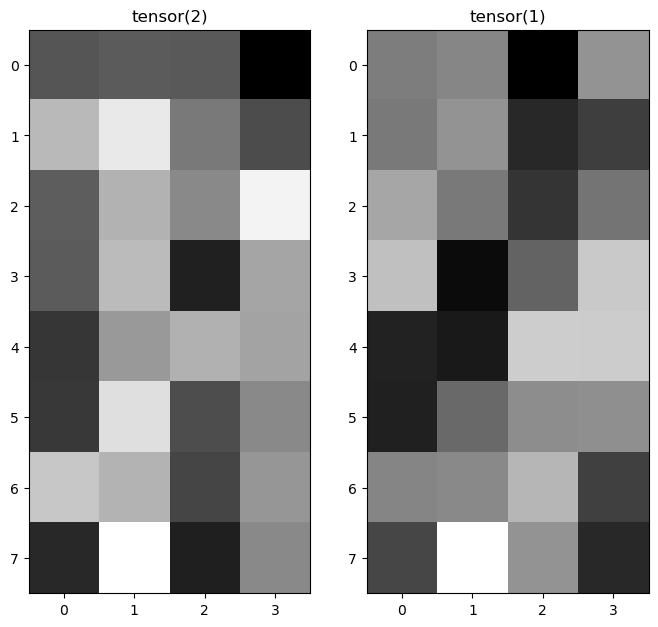

In [182]:
# Visualize the first 32 latent vectors as grayscale images
fig, axes = plt.subplots(1, 2, figsize=(8, 16))

for i, batch in enumerate(train_latent_dataloader):
    if i == 1:  # only plot the first batch
        latent_vectors, labels = batch
        print(train_latent_vectors.shape)
        break

train_latent_vectors = train_latent_vectors

for i, ax in enumerate(axes.flat):
    ax.imshow(train_latent_vectors[i].reshape(8, 4), cmap='gray') # manually change to match L_dim
    ax.set_title(labels[i])
    # ax.axis('on')

plt.show()


# Build a denoising U-Net with Self-Attention

In [184]:
class SelfAttention(nn.Module):
    def __init__(self, channels, embed_dim):
        super(SelfAttention, self).__init__()
        
        # Linear layers for query, key, value, but now based on 'channels' rather than hidden dimensions
        self.query = nn.Conv1d(channels, embed_dim, kernel_size=1)
        self.key = nn.Conv1d(channels, embed_dim, kernel_size=1)
        self.value = nn.Conv1d(channels, embed_dim, kernel_size=1)
        
        # Projection layer to return to the original channels dimension
        self.out_proj = nn.Conv1d(embed_dim, channels, kernel_size=1)

    def forward(self, x):
        # Input shape: [batch_size, channels, values]
        
        # Compute query (Q), key (K), value (V) matrices
        Q = self.query(x)  # Shape: [batch_size, values, embed_dim]
        K = self.key(x)    # Shape: [batch_size, values, embed_dim]
        V = self.value(x)  # Shape: [batch_size, values, embed_dim]
        
        # Compute attention scores (scaled dot-product attention)
        attn_weights = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(K.size(-1))  # Shape: [batch_size, values, values]
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Shape: [batch_size, values, values]
        
        # Apply attention weights to the values (V)
        attn_output = torch.bmm(attn_weights, V)  # Shape: [batch_size, values, embed_dim]
        
        # Project the attention result back to the original channel dimensions
        output = self.out_proj(attn_output)  # Shape: [batch_size, values, channels]
        
        return output

class UNetResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=5, stride=2, padding=2), # Changing kernel sizes
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5)
        )

        # If input and output dimensions are different, use a 1x1 conv to match them
        if in_channels != out_channels:
            self.residual_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=2)
        else:
            self.residual_conv = None

        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.conv2(out)

        # If dimensions differ, apply the residual conv
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        out += residual
        out = self.relu(out)
        return out

class UNetTransposeResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetTransposeResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU()
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_channels, eps=1e-5)

        )

        # If input and output dimensions are different, use a ConvTranspose1d to match them
        if in_channels != out_channels:
            self.residual_conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1)
        else:
            self.residual_conv = None

        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.conv2(out)

        # If dimensions differ, apply the residual conv
        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        out += residual
        out = self.relu(out)
        return out


In [185]:
class UNet1D(nn.Module):
    def __init__(self, latent_dim=64, embed_dim=32, hidden_channels=64, num_classes=10):
        super(UNet1D, self).__init__()

        # The number of input channels is the sum of latent_dim and embed_dim
        self.in_channels = latent_dim + embed_dim
        self.embed_dim = embed_dim
        
        # Class embedding for conditioning
        self.class_embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        # self.attn0 = SelfAttention(self.in_channels, embed_dim)
        self.resblock0 = UNetResidualBlock(self.in_channels, hidden_channels)


        # Encoder residual blocks and attention
        self.attention1 = SelfAttention(hidden_channels, embed_dim)
        self.resblock1 = UNetResidualBlock(hidden_channels, hidden_channels)
        self.resblock2 = UNetResidualBlock(hidden_channels, 2 * hidden_channels)

        # Bottleneck
        self.bottleneck_conv = nn.Conv1d(2 * hidden_channels, 4 * hidden_channels, kernel_size=3, padding=1)

        # Decoder transposed residual blocks
        self.Tresblock1 = UNetTransposeResidualBlock(4 * hidden_channels + 2 * hidden_channels, 2 * hidden_channels)
        self.Tresblock2 = UNetTransposeResidualBlock(2 * hidden_channels + hidden_channels, hidden_channels)

        # Attention in the decoder
        self.attention2 = SelfAttention(hidden_channels, embed_dim)

        # Output layers with added max pooling to reduce dimensions
        self.output_conv1 = nn.Conv1d(hidden_channels, latent_dim, kernel_size=3, padding=1)
        self.output_bn1 = nn.BatchNorm1d(latent_dim, eps=1e-5)
        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)  # Max pooling to halve the spatial dimensions

        self.output_conv2 = nn.Conv1d(latent_dim, latent_dim, kernel_size=3, padding=1)
        self.output_bn2 = nn.BatchNorm1d(latent_dim)

    def forward(self, x, class_label):
        # Class conditioning: convert class label to embedding
        class_embed = self.class_embedding(class_label)  # Shape [batch_size, embed_dim]
        class_embed = class_embed.unsqueeze(-1)  # Add dimension for concatenation with x
        
        # Ensure x has 3 dimensions for concatenation
        if x.dim() == 2:
            x = x.unsqueeze(-1)  # Shape [batch_size, latent_dim, 1]
        
        # Concatenate class embedding with input at each step
        x = torch.cat([x, class_embed], dim=1)  # Shape [batch_size, latent_dim + embed_dim, 1]

        # Encoding path
        # attn0 = self.attn0(x)
        res0 = self.resblock0(x)
        
        res1 = self.resblock1(res0)  # Residual Block 1
        # print(f"res1 Shape: {res1.shape}")

        attn1 = self.attention1(res1)  # Attention after Residual Block 1
        # print(f"attn1 Shape: {attn1.shape}")

        res2 = self.resblock2(attn1)  # Residual Block 2
        # print(f"res2 Shape: {res2.shape}")


        # Bottleneck
        bottleneck = F.relu(self.bottleneck_conv(res2))  # Bottleneck layer

        # Decoding path with skip connections
        tres1 = self.Tresblock1(torch.cat([bottleneck, res2], dim=1))  # Concatenate bottleneck and res2
        # print(f"tres1 Shape: {tres1.shape}")

        # Upsample tres1 to match the size of res1 for concatenation
        tres1_upsampled = F.interpolate(tres1, size=res1.shape[-1])
        # print(f"tres1_upsampled Shape: {tres1_upsampled.shape}")

        tres2 = self.Tresblock2(torch.cat([tres1_upsampled, res1], dim=1))  # Concatenate with earlier encoder layer
        attn2 = self.attention2(tres2)  # Attention block in decoder
        # print(f"attn2 Shape: {attn2.shape}")
        attn2 = attn2+attn1


        # Output layers with max pooling to reduce dimensions
        output = F.relu(self.output_bn1(self.output_conv1(attn2)))  # First output conv layer
        output = -1*self.max_pool(-1*output)  # Janky min pooling
        output = self.output_conv2(output)  # Second output conv layer
        
        return output


In [186]:
# Simple diffusion process (no change needed here for class conditioning)
def diffusion_step(x, t, noise):
    return torch.sqrt(1 - t) * x + torch.sqrt(t) * noise  # Dodge t=0

# Denoising step
def denoising_step(model, x, t, class_label):
    # Pass both latent vector and class label through the model (U-Net)
    noise_pred = model(x, class_label)  
    
    # Ensure x and noise_pred have the same shape for subtraction
    if noise_pred.shape != x.shape:
        noise_pred = noise_pred.view_as(x)  # Reshape if necessary
    
    # Gradually remove the noise from x
    return x - noise_pred


def latent_regularization_loss(output, epoch):
    return np.log(epoch+1) * torch.sum(output ** 2)  


# Training loop for LDM with class conditioning
def train_ldm(unet, dataloader, epochs=10):

    weight_decay = 1e-5
    optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3, weight_decay = weight_decay)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9, weight_decay = weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, 'min')


    for epoch in range(epochs):
        running_loss = 0.0
        for batch in dataloader:
            latent_vectors, labels = batch  # Now include labels in the batch
            
            noise = torch.randn_like(latent_vectors)
            
            # Simulate a diffusion step
            t = torch.rand(latent_vectors.size(0), 1)  # Random timestep for each batch
            noised_latent = diffusion_step(latent_vectors, t, noise)
            
            # Denoise using U-Net, pass the class labels to condition the model
            denoised_latent = denoising_step(unet, noised_latent, t, labels)
            
            # Loss function (MSE for now)
            loss = F.mse_loss(denoised_latent, latent_vectors) 
            # + latent_regularization_loss(denoised_latent, epoch)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm = 0.5)
            optimizer.step()
            running_loss +=loss.item()
            
        plt.scatter(epoch, running_loss, color = 'r')
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
            
        if epoch%5 ==0: 
            # Additional information
            PATH = "unet.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': unet.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': running_loss,
                }, PATH)


# Visualize Latent Space after Denoising (8x4 Grid)
def visualize_denoised_latent(model, dataloader):
    model.eval()
    batch = next(iter(dataloader))
    labels = batch[1]
    latent_vectors = batch[0]
    with torch.no_grad():
        denoised_latent = model(latent_vectors, labels)
        
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(denoised_latent[i].squeeze(0).cpu().reshape(8,4), cmap='gray')
        ax.set_title(labels[i])
    plt.show()

Epoch [1/25], Loss: 4.4655
Epoch [2/25], Loss: 3.1775
Epoch [3/25], Loss: 3.7559
Epoch [4/25], Loss: 2.0001
Epoch [5/25], Loss: 2.8040
Epoch [6/25], Loss: 1.8957
Epoch [7/25], Loss: 1.7872
Epoch [8/25], Loss: 2.3293
Epoch [9/25], Loss: 2.5833
Epoch [10/25], Loss: 2.5136
Epoch [11/25], Loss: 2.1880
Epoch [12/25], Loss: 3.7354
Epoch [13/25], Loss: 2.9582
Epoch [14/25], Loss: 2.5904
Epoch [15/25], Loss: 1.7844
Epoch [16/25], Loss: 2.6164
Epoch [17/25], Loss: 2.2532
Epoch [18/25], Loss: 3.1004
Epoch [19/25], Loss: 1.7527
Epoch [20/25], Loss: 2.9446
Epoch [21/25], Loss: 2.4356
Epoch [22/25], Loss: 2.4402
Epoch [23/25], Loss: 1.8576
Epoch [24/25], Loss: 1.4794
Epoch [25/25], Loss: 2.2271


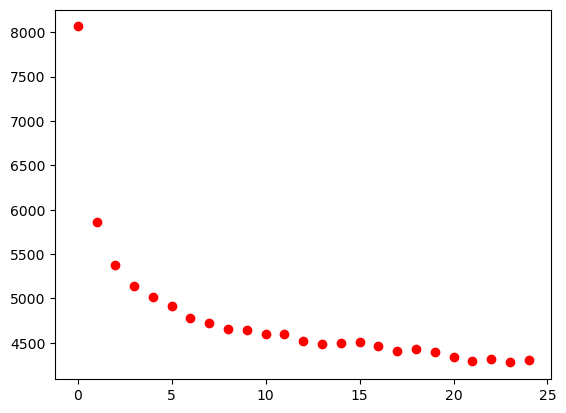

In [187]:
# Initialize the U-Net
unet = UNet1D(latent_dim = L_dim)

# Train the model
train_ldm(unet, train_latent_dataloader, epochs = 25) # yay! 

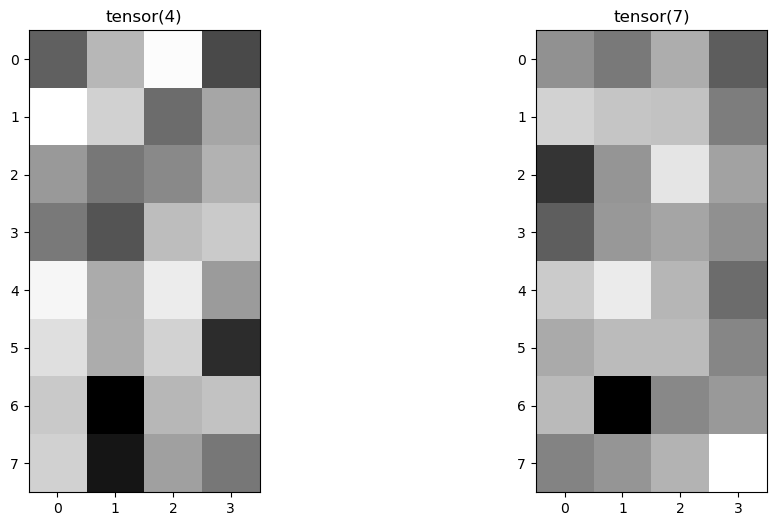

In [188]:

# Visualize the denoised latent space
visualize_denoised_latent(unet, train_latent_dataloader)

In [189]:
import torch
import matplotlib.pyplot as plt



def generate_data(model, UNet, class_label, latent_dim=32, num_steps=10):
    model.eval()
    unet.eval()  # Set U-Net to evaluation mode

    # Start with random noise as latent space initialization
    noise = torch.randn(1, latent_dim)  # Shape: [batch_size, latent_dim, 1]

    # Convert the class label into a tensor and reshape for the model
    class_label_tensor = torch.tensor([class_label], dtype=torch.long)

    # Denoising process through the trained LDM model
    for step in range(num_steps):
        t = torch.tensor([step / num_steps])  # Normalized timestep
        noise = denoising_step(unet, noise, t, class_label_tensor)
        print(noise[0])

    # Pass the final denoised latent vector through the decoder to generate an image
    with torch.no_grad():
        decoded_image = model.decoder(noise)

    return decoded_image

# Function to generate a single image with a given class label
def generate_image(model, UNet, class_label, latent_dim=32, num_steps=100):
    model.eval()
    unet.eval()  # Set U-Net to evaluation mode

    # Start with random noise as latent space initialization
    noise = torch.randn(1, latent_dim)  # Shape: [batch_size, latent_dim, 1]

    # Convert the class label into a tensor and reshape for the model
    class_label_tensor = torch.tensor([class_label], dtype=torch.long)

    # Denoising process through the trained LDM model
    for step in range(num_steps):
        t = torch.tensor([step / num_steps])  # Normalized timestep
        noise = denoising_step(unet, noise, t, class_label_tensor)

    # Pass the final denoised latent vector through the decoder to generate an image
    with torch.no_grad():
        decoded_image = model.decoder(noise)

    # Reshape and visualize the image (assuming it is 28x28 pixels)
    generated_image = decoded_image.view(28, 28).cpu().numpy()

    # Show the generated image
    plt.imshow(generated_image, cmap='gray')
    plt.title(f"Generated Image with Label {class_label} and {num_steps} steps")
    plt.axis('off')
    plt.show()

# Usage:
# Assuming `unet_model` is your U-Net and `decoder_model` is your trained decoder
# generate_image(model, unet, 1)

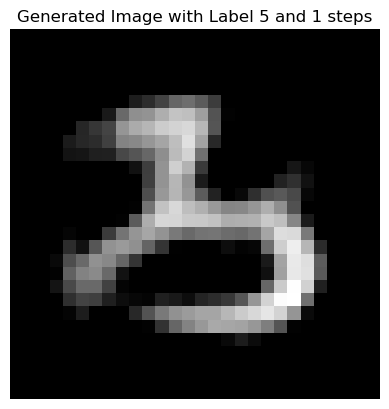

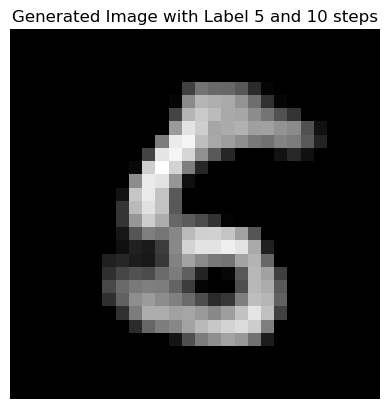

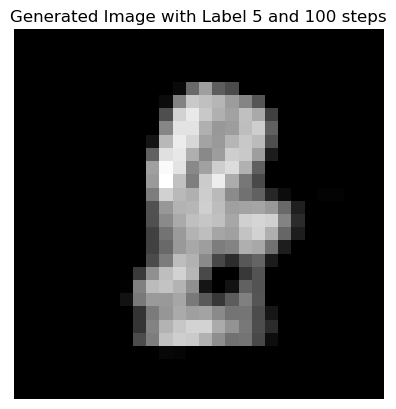

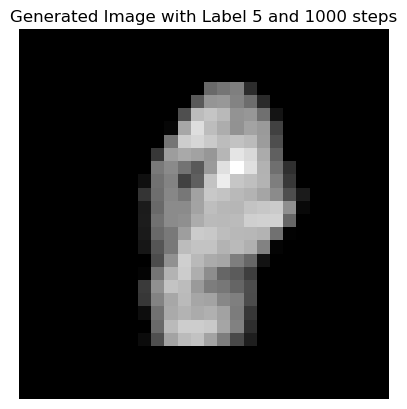

(None, None, None, None)

In [190]:
tgt = 5
generate_image(model, unet, tgt, num_steps=1), generate_image(model, unet, tgt, num_steps=10), generate_image(model, unet, tgt, num_steps=100), generate_image(model, unet, tgt, num_steps=1000)

# Let's show it off!
And figure out how mamy denoising steps are best fit for the task! 

In [192]:
import torch
import matplotlib.pyplot as plt

# Generate and collect images for each class and step
def generate_grid_images(model, UNet, latent_dim=32, steps=[1, 10, 100, 1000]):
    fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(24, 12))
    
    # Iterate over class labels (0-9) and denoising steps (1, 10, 100, 1000)
    for row, num_steps in enumerate(steps):
        for col in range(10):  # 0 through 9 class labels
            generated_image = generate_image_for_grid(
                model, UNet, col, latent_dim, num_steps
            )
            
            # Plot the generated image on the corresponding subplot
            axes[row, col].imshow(generated_image, cmap='gray')
            axes[row, col].axis('off')
            
            # Add titles for the top row only (digits 0-9)
            if row == 0:
                axes[row, col].set_title(f"{col}", fontsize=12)

    # Add a vertical label for rows to indicate denoising steps
        
            axes[row, col].set_title(f"{col} : {num_steps} steps", fontsize = 16)
            # axes[row, col].set_xlabel(f"Generated {col}", fontsize = 12)

    plt.tight_layout()
    plt.show()

# Generate a single image without displaying it (to use in grid)
def generate_image_for_grid(model, UNet, class_label, latent_dim=64, num_steps=100):
    model.eval()
    UNet.eval()  # Set U-Net to evaluation mode

    # Initialize latent space with random noise
    noise = torch.randn(1, latent_dim)  # Shape: [1, latent_dim]

    # Convert class label to tensor
    class_label_tensor = torch.tensor([class_label], dtype=torch.long)

    # Denoising loop
    for step in range(num_steps):
        t = torch.tensor([step / num_steps])  # Normalized timestep
        noise = denoising_step(UNet, noise, t, class_label_tensor)

    # Decode the final latent space into an image
    with torch.no_grad():
        decoded_image = model.decoder(noise)

    # Reshape to 28x28 and return the result
    return decoded_image.view(28, 28).cpu().numpy()

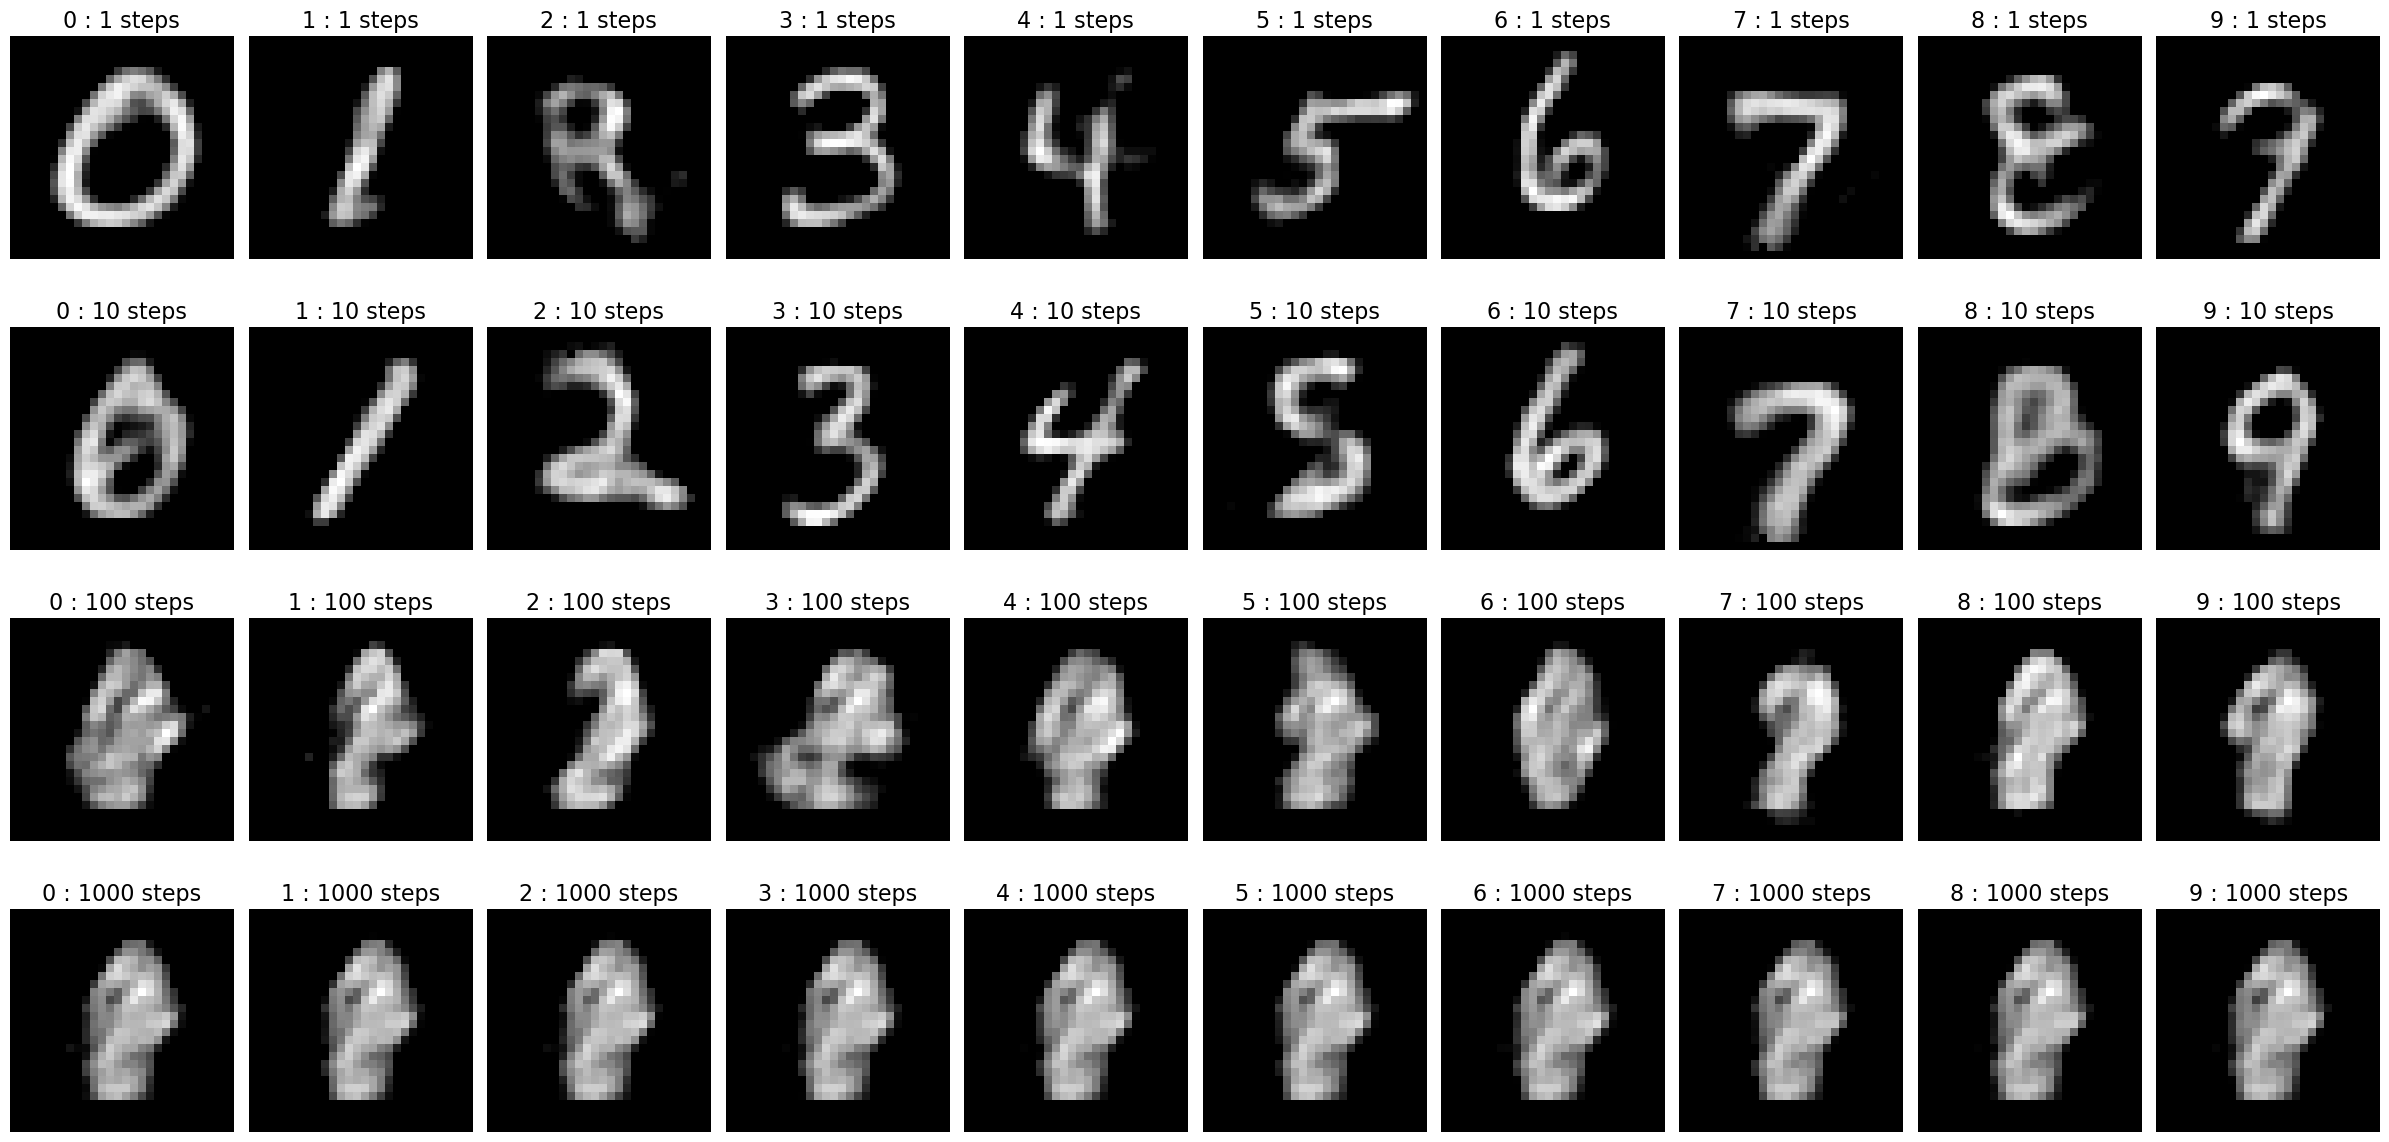

In [221]:
# Example usage (assuming `ldm_model` is your autoencoder and `unet` is your U-Net):
generate_grid_images(model, unet, latent_dim = 32, steps = [1, 10, 100, 1000])

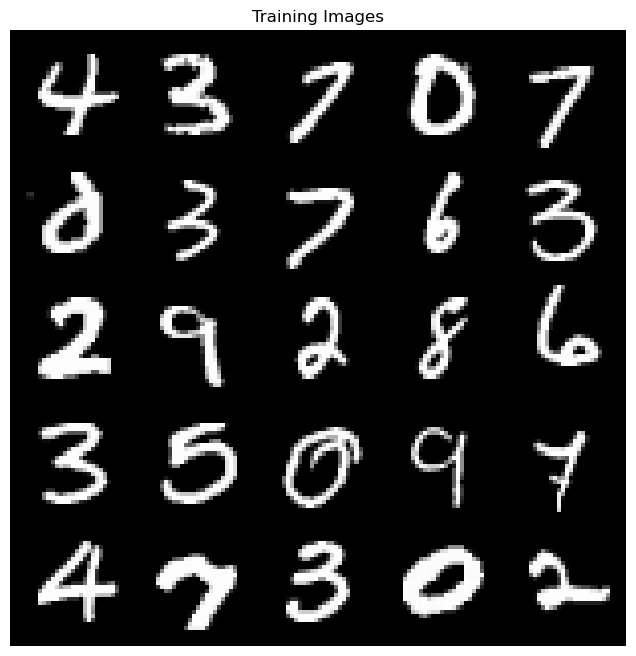

In [218]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to plot a grid of images from the dataloader
def plot_training_images(dataloader, num_images=25):
    """
    Plots a grid of training images from the dataloader.
    num_images: Total number of images to plot (must be a perfect square).
    """
    # Extract a single batch from the dataloader
    images, labels = next(iter(dataloader))

    # Limit the number of images to display
    images = images[:num_images]

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=int(num_images ** 0.5), normalize=True)

    # Plot the grid
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())  # Convert from CHW to HWC
    plt.axis('off')
    plt.title("Training Images")
    plt.show()

# Example usage (assuming you have `train_dataloader` ready):
plot_training_images(train_dataloader, num_images=25)
